# 실습:  CNN을 이용한 폐렴 검출

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import random

In [ ]:
import tensorflow as tf

# To Avoid GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 299
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2BGR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        # Get the list of image filenames in the training directory
        image_filenames = os.listdir(path)

        # Randomly select 500 filenames
        selected_filenames = random.sample(image_filenames, 500)

        for filename in selected_filenames:
            try:
                img_path = os.path.join(path, filename)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2BGR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])

            except Exception as e:
                print(e)
    
    return np.array(data)

In [ ]:
cd drive/MyDrive/datasets/uni/archive

/content/drive/MyDrive/datasets/uni/archive


In [ ]:
train = get_training_data('./chest_xray/train')
test = get_data('./chest_xray/test')
val = get_data('./chest_xray/val')

<ipython-input-5-06c4f87f37d7>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)
<ipython-input-4-f38a32f00a34>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


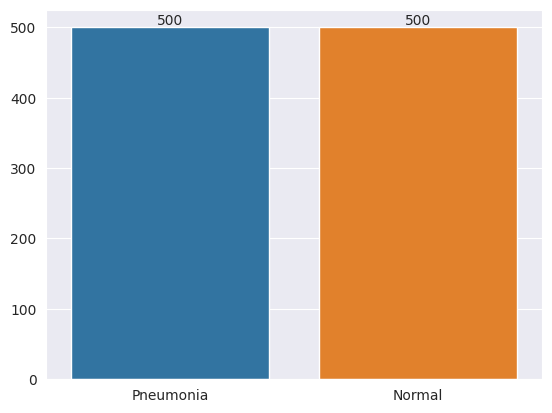

In [ ]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
count_data = pd.Series(l).value_counts()
ax = sns.barplot(x=count_data.index, y=count_data.values)

# Add count labels to the bars
for i, v in enumerate(count_data.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()

Text(0.5, 1.0, 'NORMAL')

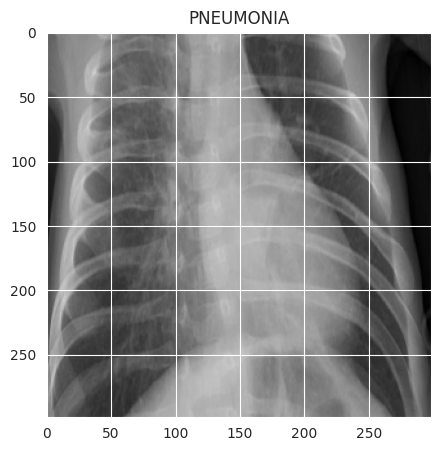

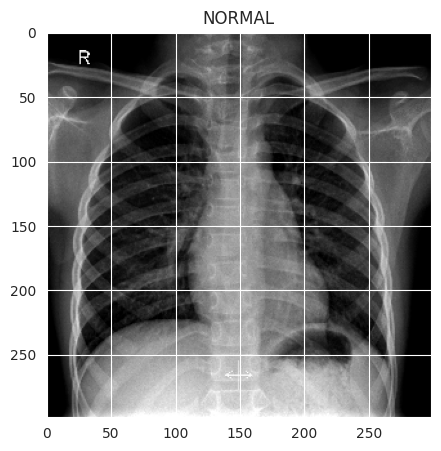

In [ ]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [ ]:
# 데이터를 Normalize 0~255  --->   0~1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [ ]:
from keras.applications import InceptionV3
# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


In [ ]:
# Unfreeze some layers for fine-tuning
unfreeze_layers = 100
for layer in base_model.layers[:-unfreeze_layers]:
    layer.trainable = False
for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

In [ ]:
# Add custom classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

In [ ]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, batch_size = 16,epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
63/63 [==============================] - 27s 159ms/step - loss: 0.2516 - accuracy: 0.9200 - val_loss: 1.5000 - val_accuracy: 0.8750
Epoch 2/10
63/63 [==============================] - 6s 100ms/step - loss: 0.0940 - accuracy: 0.9620 - val_loss: 0.6576 - val_accuracy: 0.9375
Epoch 3/10
63/63 [==============================] - 6s 102ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 6s 100ms/step - loss: 0.0263 - accuracy: 0.9890 - val_loss: 7.7843e-04 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 6s 102ms/step - loss: 0.0673 - accuracy: 0.9720 - val_loss: 0.0716 - val_accuracy: 0.9375
Epoch 6/10
63/63 [==============================] - 6s 102ms/step - loss: 0.0405 - accuracy: 0.9840 - val_loss: 1.3704 - val_accuracy: 0.6250
Epoch 7/10
63/63 [==============================] - 7s 103ms/step - loss: 0.0233 - accuracy: 0.9910 - val_loss: 0.0677 - val_accuracy: 0.9375
E

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 7s 131ms/step - loss: 1.0434 - accuracy: 0.8333
Loss of the model is -  1.0434300899505615
20/20 [==============================] - 3s 123ms/step - loss: 1.0434 - accuracy: 0.8333
Accuracy of the model is -  83.33333134651184 %


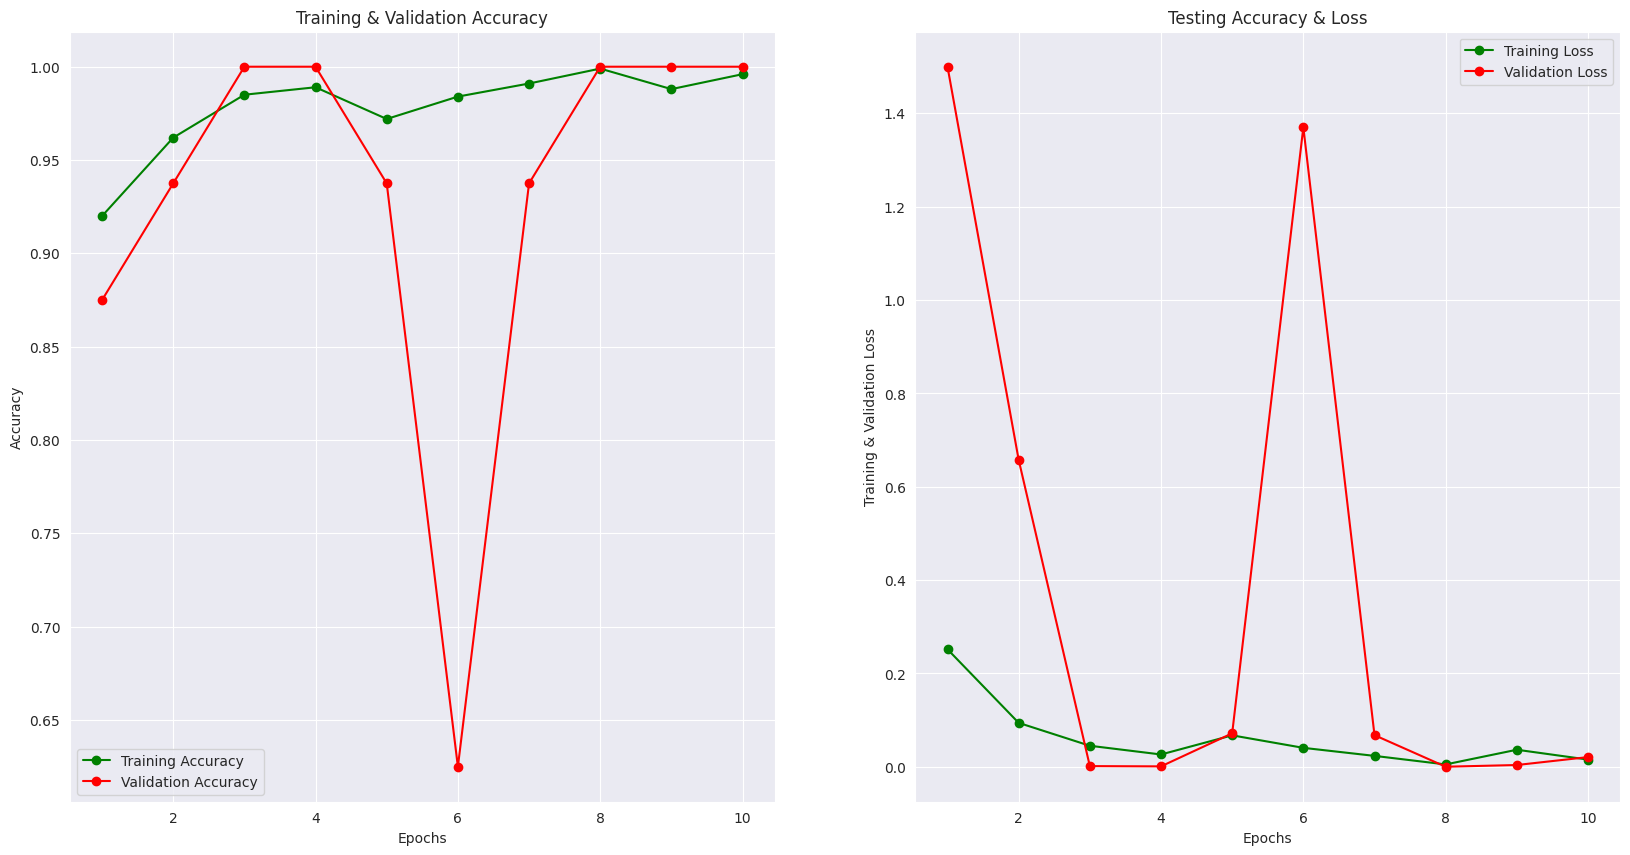

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)

epochs = range(1, len(train_acc) + 1)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)


20/20 [==============================] - 4s 121ms/step


In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

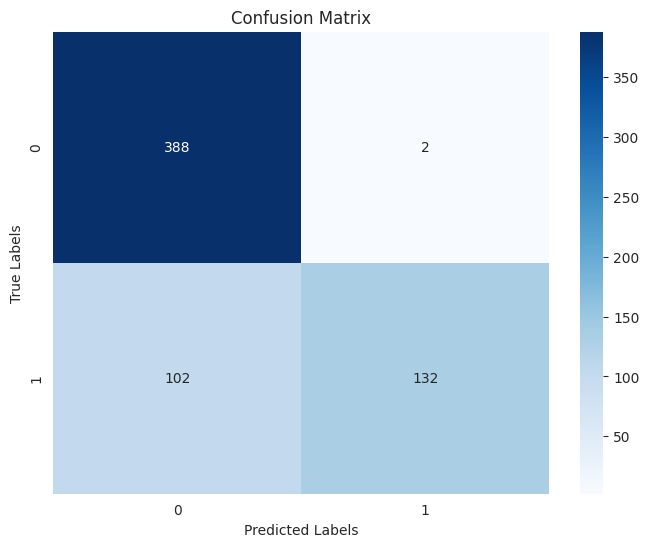

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Plot the classification report
target_names = ['PNEUMONIA', 'NORMAL']
classification_rep = classification_report(y_test, y_pred_labels, target_names=target_names)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

   PNEUMONIA       0.79      0.99      0.88       390
      NORMAL       0.99      0.56      0.72       234

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624

